In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date = latest_date[0]
latest_date


'2017-08-23'

In [10]:
# Convert the string '2017-08-23' to a datetime object
latest_date_datetime = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date_datetime

datetime.datetime(2017, 8, 23, 0, 0)

In [11]:
# Convert the string '2017-08-23' to a datetime object
latest_date_datetime = dt.datetime.strptime(latest_date, '%Y-%m-%d')

# Calculate one year before the latest date

delta_date = latest_date_datetime-dt.timedelta(days=365)
delta_date = delta_date.strftime('%Y-%m-%d')
delta_date

'2016-08-23'

/var/folders/21/spl45bvj2fg45pcvjs5jk5z40000gn/T/ipykernel_2522/1279617083.py:20: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


<function matplotlib.pyplot.show(close=None, block=None)>

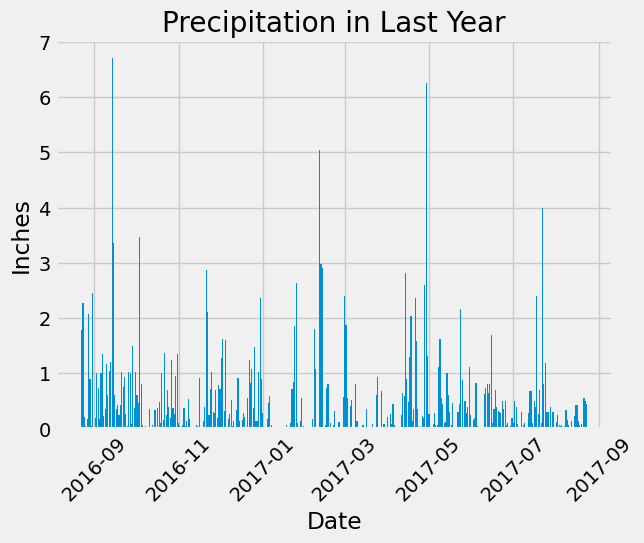

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 



# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, measurement.prcp]

year = session.query(*sel).filter(measurement.date <= latest_date, measurement.date >= delta_date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(year, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
sorted_df = df.sort_values(['Date'])
sorted_df["Date"] = pd.to_datetime(sorted_df["Date"])

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(sorted_df["Date"],sorted_df["Precipitation"])
plt.locator_params(axis='x', nbins=10)
plt.title('Precipitation in Last Year')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show


In [14]:
sorted_df["Date"] = pd.to_datetime(sorted_df["Date"])
sorted_df

,Date,Precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(station.station).count()
print(f"There are {station_count} stations")

There are 9 stations


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
single_most_active_station = most_active_stations[0][0]
single_most_active_station

'USC00519281'

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# create a list of the columns that need to be queried
list_col_most_active = [measurement.station,
                        func.min(measurement.tobs),
                        func.max(measurement.tobs),
                        func.avg(measurement.tobs)
                        ]
stats_most_active = session.query(*list_col_most_active).filter(measurement.station == single_most_active_station).all()
stats_most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [20]:
station_id_most_active = stats_most_active[0][0]
station_id_most_active

'USC00519281'

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date_most_active_station = session.query(measurement.date).order_by(measurement.date.desc()).filter(measurement.station == station_id_most_active).first()
latest_date_most_active_station = latest_date_most_active_station[0]

# Convert the string '2017-08-18' to a datetime object
latest_date_datetime = dt.datetime.strptime(latest_date_most_active_station, '%Y-%m-%d')

# Calculate one year before the latest date

one_year = latest_date_datetime-dt.timedelta(days=365)
one_year = one_year.strftime('%Y-%m-%d')
one_year

results = session.query(measurement.tobs).filter(measurement.date <= latest_date_most_active_station, measurement.date >= one_year).filter(measurement.station == station_id_most_active).all()
results_df = pd.DataFrame(results)

results_df

,tobs
0,80.0
1,79.0
2,81.0
3,79.0
4,78.0
...,...
352,77.0
353,77.0
354,76.0
355,76.0


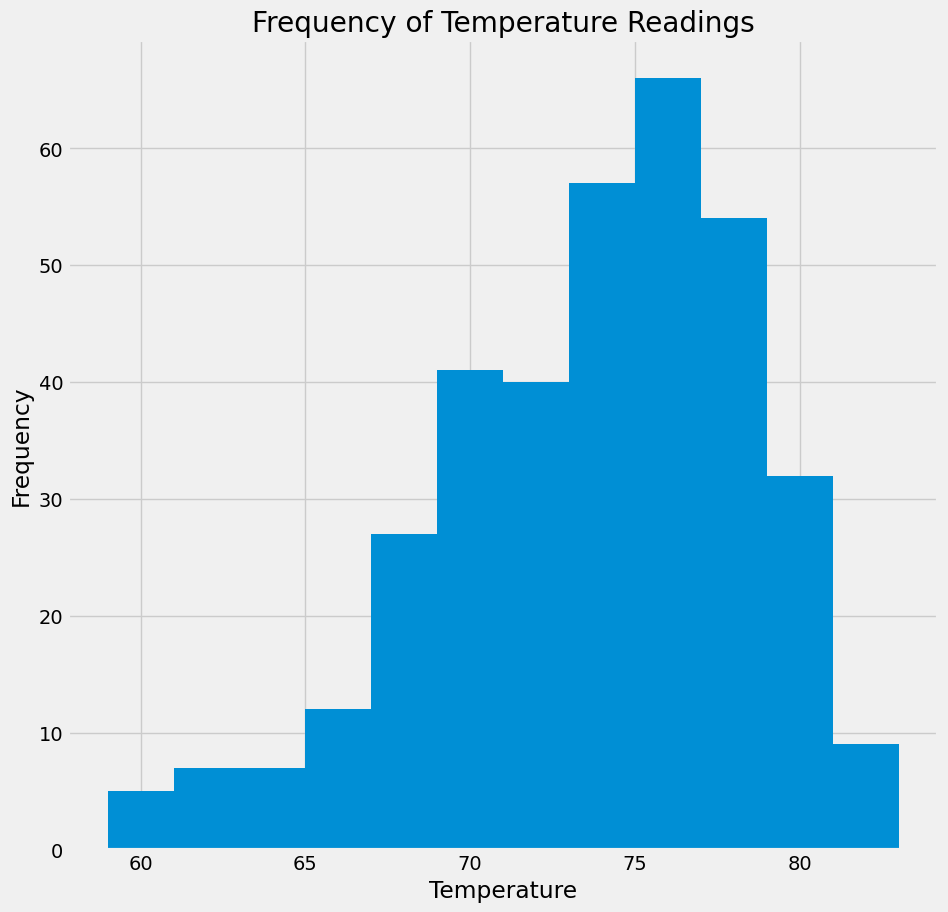

In [22]:
results_df.hist(figsize=[10, 10], bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title('Frequency of Temperature Readings')
plt.show()

# Close Session

In [23]:
# Close Session
session.close()